# Local OOR detection

In this tutorial, we will go through the methods for local OOR detection. We recommend that users first read the Introduction to **Global and Local OOR Detection section** and then choose the method that best suits their needs. Here, we use a preprocessed pseudo-disease dataset as an example.

In [27]:
## load epipack package

# !pip install --upgrade epipackpy
import scanpy as sc
import numpy as np
import pandas as pd

import epipackpy as epk
print(epk.__version__)

1.0.1dev4


In [8]:
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()

Load the simulated data.

In [3]:
A_sim_ = sc.read_h5ad("Fig5_experiment/pbmc_local_oor_detection_result.h5ad")

Please make sure your data also include an obs column named "dataset_group", in which it contains "query" and "atlas" labels. This can be easily added by using 

```
REF_DATASET.obs['dataset_group'] = 'atlas'
QUUERY_DATASET.obs['dataset_group'] = 'query'
```

before integration with the query.

In [5]:
#dataset.obs['dataset_group']
A_sim_.obs['dataset_group']

AAACGAAAGACGTCAG-1    query
AAACGAAAGATTGACA-1    query
AAACGAAAGGGTCCCT-1    query
AAACGAACAATTGTGC-1    query
AAACGAACACTCGTGG-1    query
                      ...  
TTTGTGTTCGGTACGC-1    atlas
TTTGTGTTCTAATCCT-1    atlas
TTTGTTGGTAAGGTTT-1    atlas
TTTGTTGGTTAGGATT-1    atlas
TTTGTTGGTTTGGGCG-1    atlas
Name: dataset_group, Length: 33307, dtype: category
Categories (2, object): ['atlas', 'query']

Here we first visualization our simulated dataset. The OOR state shows the simulated local OOR cells. Please see our paper for data simulation method.

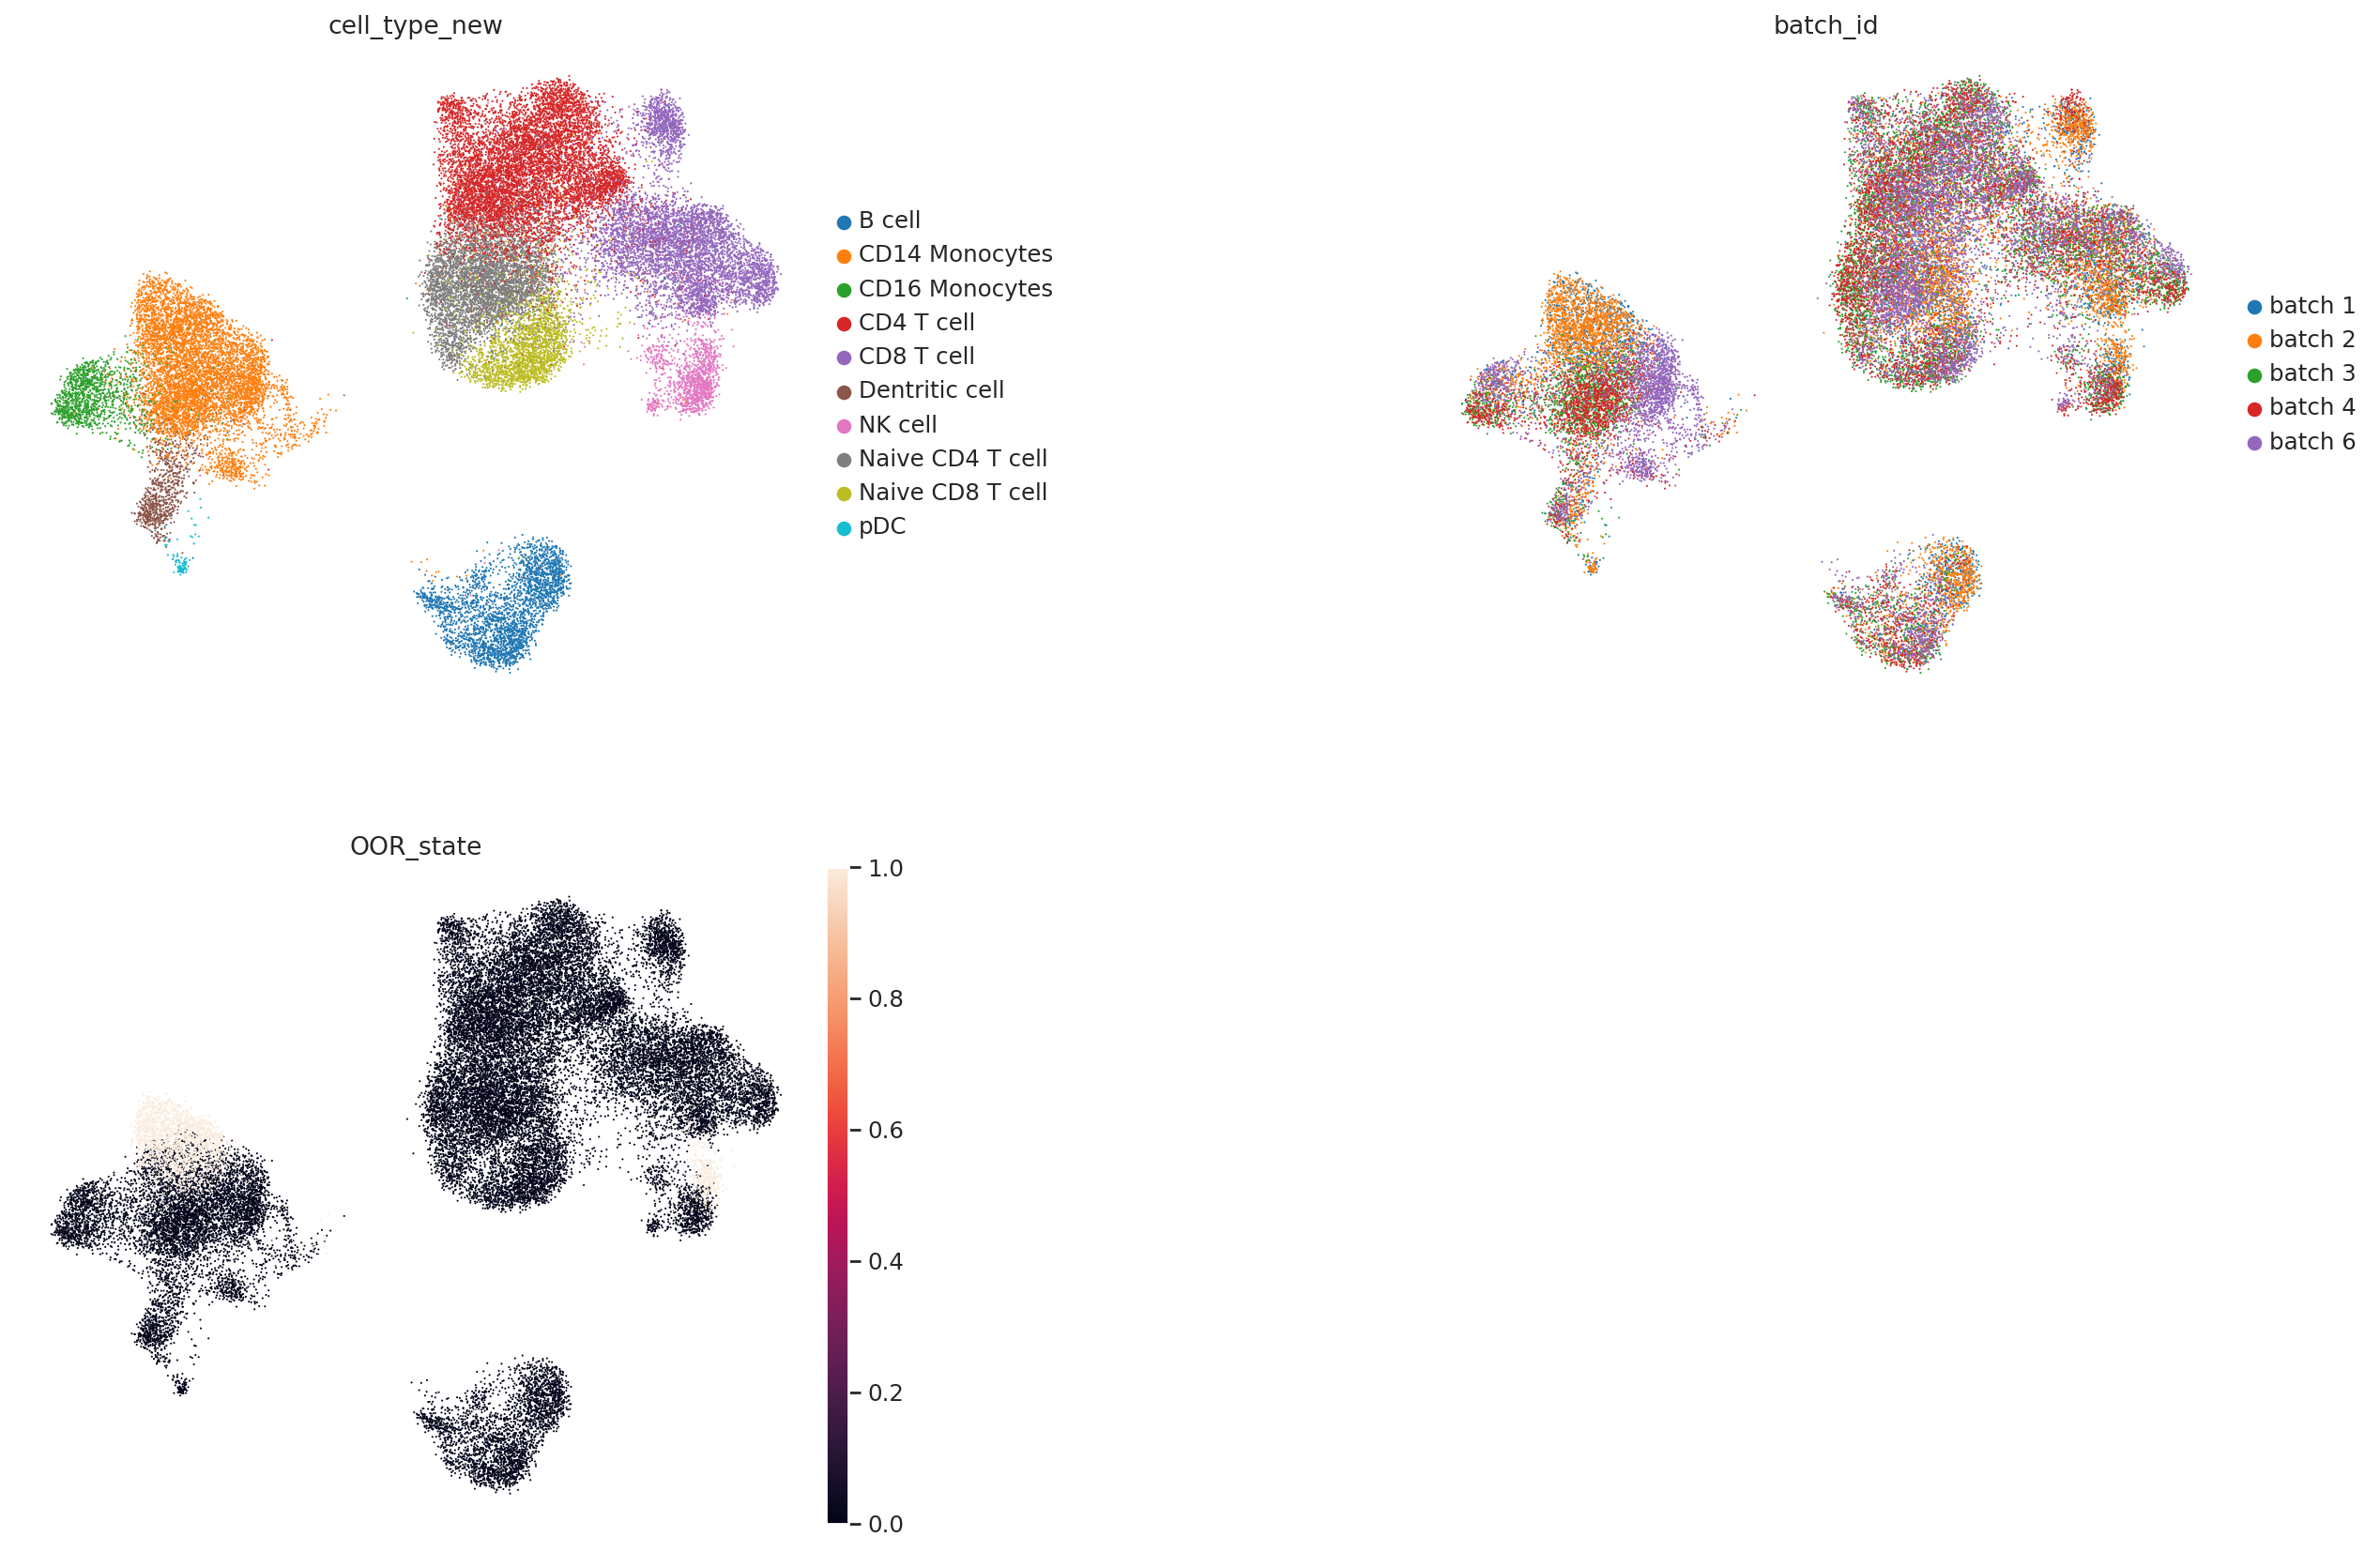

In [9]:
sc.pp.neighbors(A_sim_, n_neighbors=50, use_rep='z_ref')
sc.tl.umap(A_sim_)
#sc.tl.leiden(tmp, resolution=1.5)
sc.pl.umap(A_sim_, color=['cell_type_new', 'batch_id',"OOR_state"], ncols=2, wspace=0.6)

Here we can find that CD14 Monocytes and NK cells both include simulated OOR shifted cell states (batch 1 and 2 are query). Next, we train the local OOR detector.

In [10]:
Z = A_sim_.obsm['z_ref']
y = (A_sim_.obs['dataset_group'].values == 'query').astype(int)
batches = A_sim_.obs['batch_id'].values

res = epk.ml.local_oor_detector(
    Z, y, batches,
    k=30,
    T=20, seed=2048
)

- Constructing edge features...
- Training kernel on cuda (fp32) ...


Epochs: 100%|██████████| 50/50 [00:30<00:00,  1.64it/s, kernel_converge_loss=0.127]


- Running BRP on the graph...
- FDR control with significance value  0.1 ...
- Done!


``Res`` dataframe contains all result related to the detection result. Some of those useful terms as listed below:

- K is the trained kernel
- prob is the probability that this cell belongs to the query setting (experimental group)
- qval is significant value after FDR control
- significant is the binary result of the detected OOR cells

In [22]:
A_sim_.obs['OOR_prob']  = res['prob']
A_sim_.obs['OOR_pval']  = res['pval']
A_sim_.obs['OOR_qval']  = res['qval']
A_sim_.obs['OOR_sig_predicted']  = res['significant'].astype(int)

We visualize the probability and q value below. For CD14 Monocytes, we have

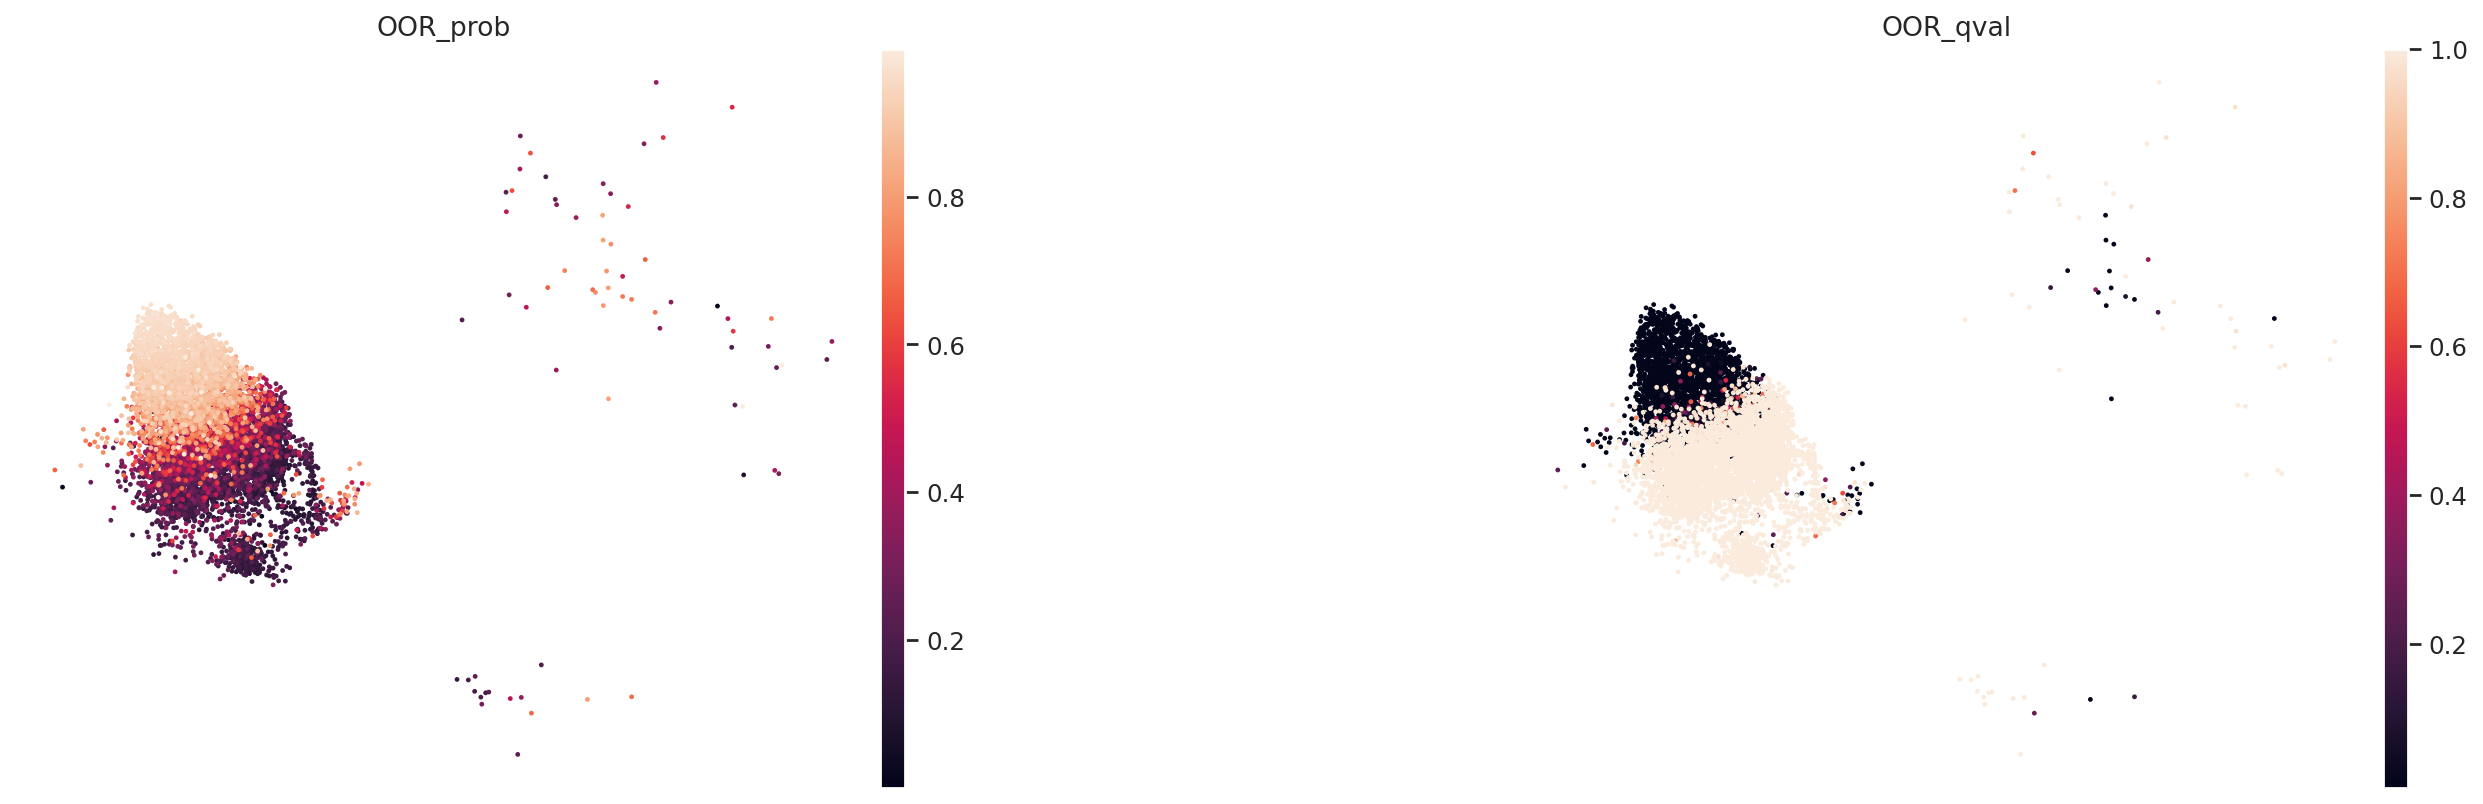

In [15]:
mask = (A_sim_.obs['cell_type_new'] == 'CD14 Monocytes').values
Z_sub = Z[mask]; y_sub = y[mask]; batches_sub = batches[mask]

sc.pl.umap(A_sim_[mask], color=['OOR_prob', "OOR_qval"], ncols=2, wspace=0.6)

We can find that our predicted local OOR cell states is largely overlapped with the ground truth OOR state label.

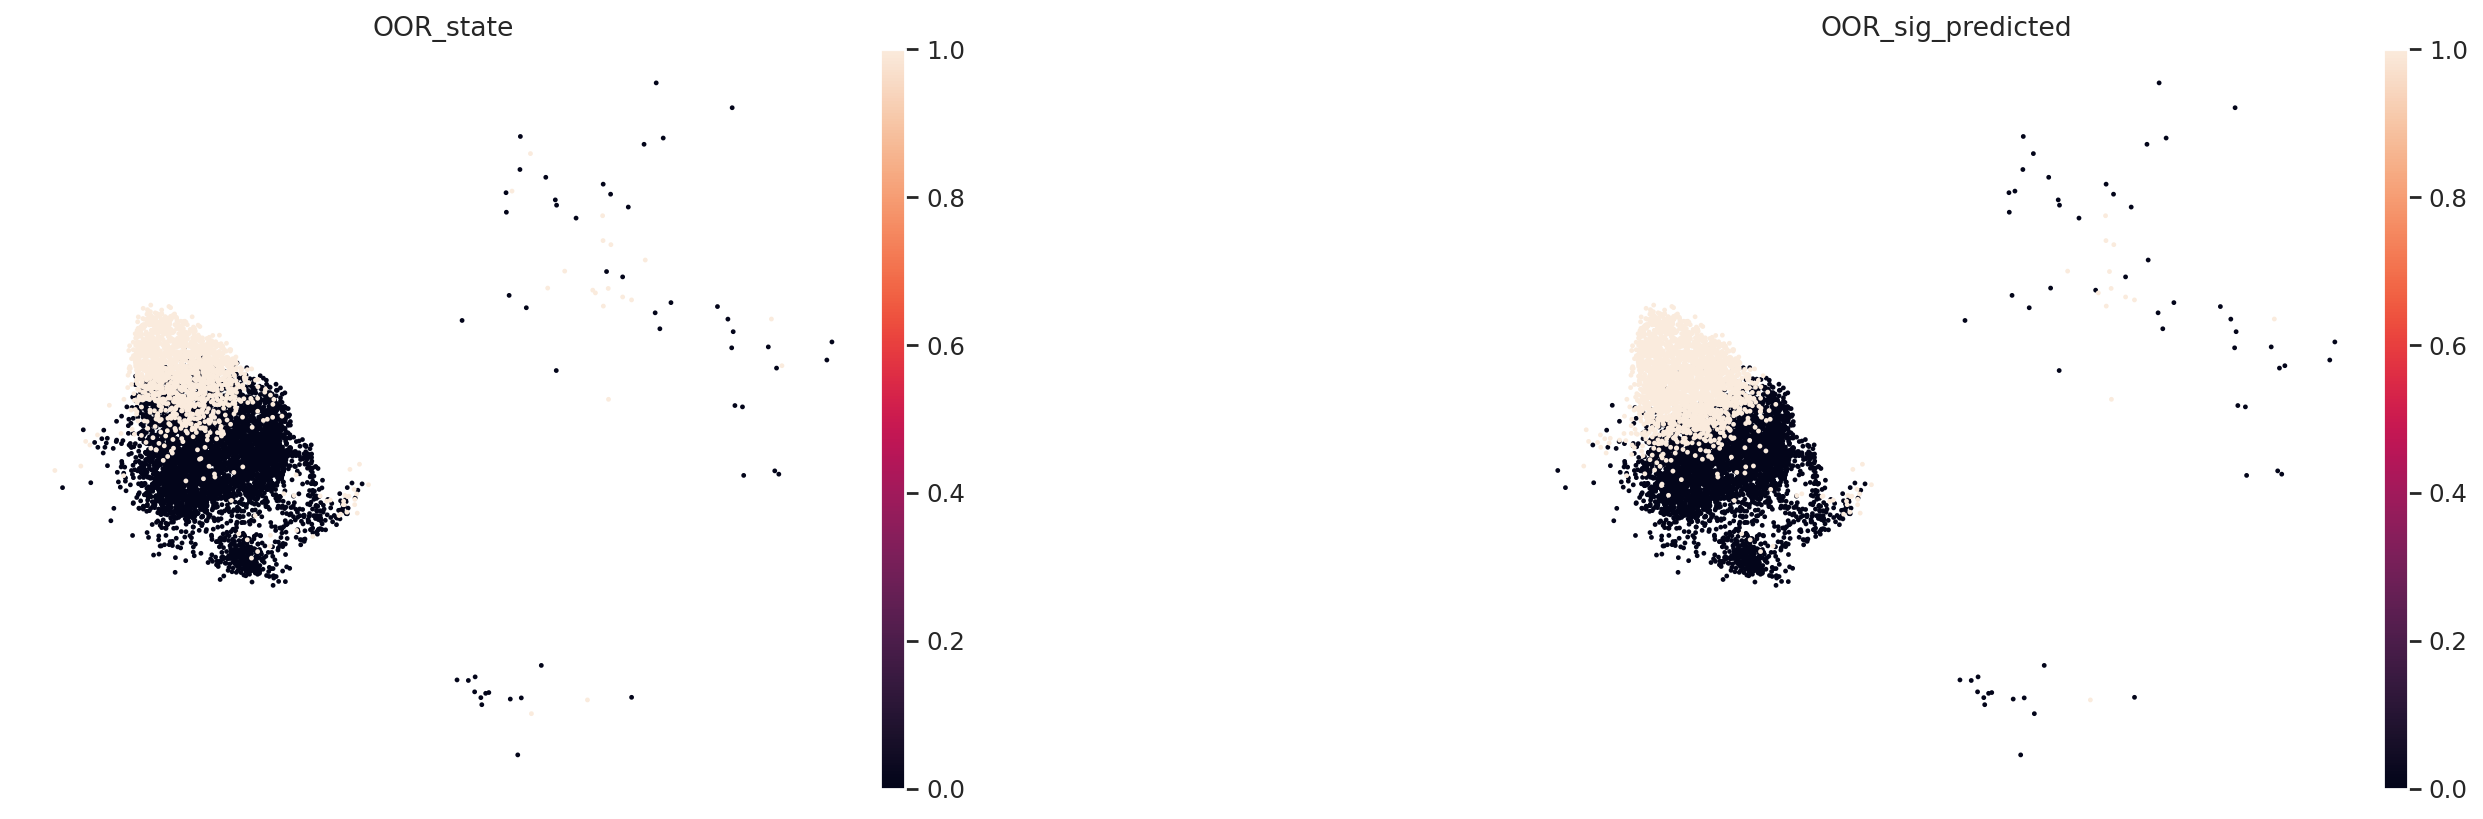

In [23]:
sc.pl.umap(A_sim_[mask], color=['OOR_state','OOR_sig_predicted'], ncols=2, wspace=0.6)

We can also calculate enrichment score.

In [ ]:
# calculate enrichment score
eps = 1e-5
p = A_sim_.obs["OOR_prob"].clip(eps, 1-eps).to_numpy()
A_sim_.obs["enrichment_score"] = np.log10(p/(1-p))

We visualize CD14 Monocyte enrichment score density map below.

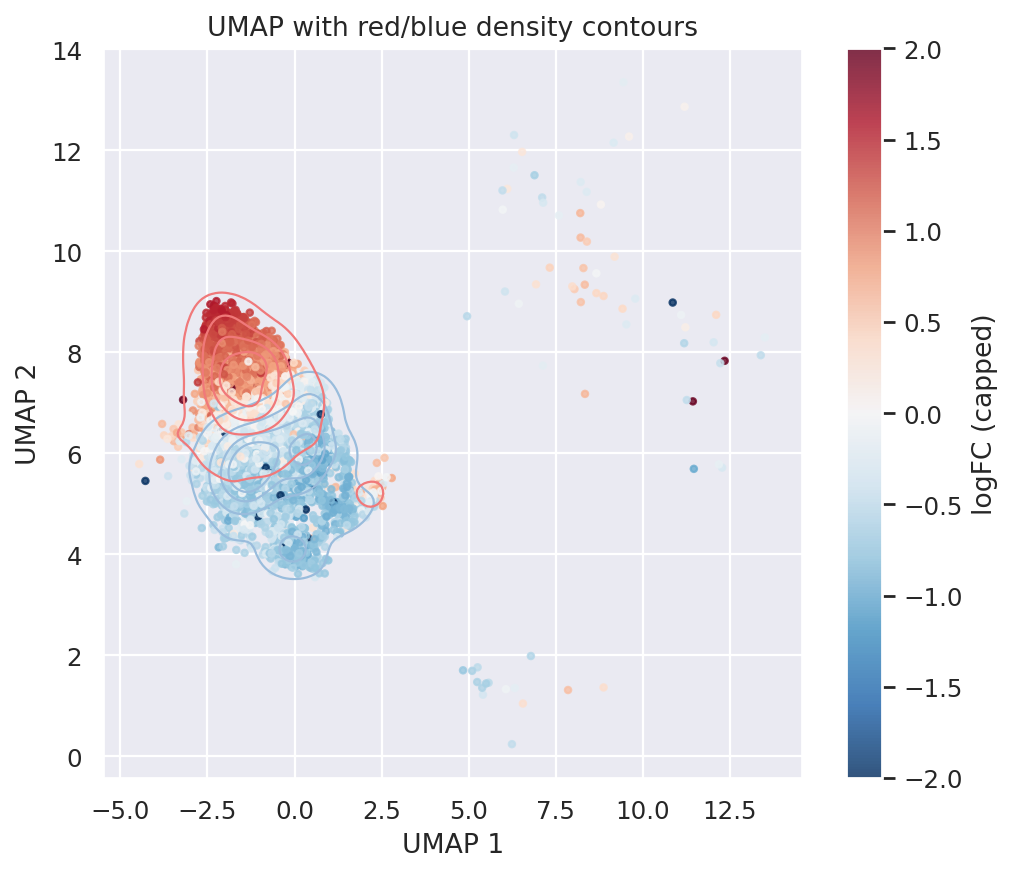

In [ ]:
umap_ = pd.DataFrame(A_sim_[mask].obsm['X_umap'],   columns=['UMAP1', 'UMAP2'])
umap_['logfc_cap'] = (
    A_sim_[mask].obs["enrichment_score"].to_numpy().clip(-2, 2)
)

#import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
#import numpy as np

plt.figure(figsize=(7,6))
sc = plt.scatter(
    umap_["UMAP1"],
    umap_["UMAP2"],
    c=umap_["logfc_cap"],
    cmap="RdBu_r", vmin=-2, vmax=2,
    s=8, alpha=0.8
)

sns.kdeplot(
    data=umap_[umap_["logfc_cap"] < 0],
    x="UMAP1", y="UMAP2",  
    levels=5,  color="#99bcdc", linewidths=1
)

sns.kdeplot(
    data=umap_[umap_["logfc_cap"] > 0],
    x="UMAP1", y="UMAP2",
    levels=5, color="#f0797a", linewidths=1
)

plt.colorbar(sc, label="logFC (capped)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP with red/blue density contours")
plt.show()